In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

In [4]:
# read CSV's to dataframes
df_base = pd.read_csv("/Users/jeremyvanvalkenburg/Repositories/datasets/analytics/export_base.csv")
df_p2p = pd.read_csv("/Users/jeremyvanvalkenburg/Repositories/datasets/analytics/export_p2p.csv")

# filter out entries w/out any visitors
df_base = df_base[(df_base.visits!=0)&(df_base.visits!=0)]
df_p2p = df_p2p[df_p2p.base.isin(df_base.id.values.tolist())]

# merge the dataframes and generate donation conversion column
df = pd.merge(df_base, df_p2p, left_on='id', right_on='base')

df['donation_conversion'] = df['don_count'] / df['visits']

df_reg = pd.read_csv("~/Repositories/datasets/analytics/analytics_p2p_registrations.csv")
df_reg = df_reg[df_reg.visits>0]
df_reg['reg_conversion'] = df['reg_count'] / df['visits']

# Observations based correlations

In [4]:
cols = ['reg_count', 'don_count', 'teams_count', 'donation_conversion']
df[cols].corr()

,reg_count,don_count,teams_count,donation_conversion
reg_count,NaN,NaN,NaN,NaN
don_count,NaN,1.000000,0.376803,0.184281
teams_count,NaN,0.376803,1.000000,0.031247
donation_conversion,NaN,0.184281,0.031247,1.000000


In [5]:
cols = ['reg_count', 'don_count', 'reg_conversion', 'teams_count']
df_reg[cols].corr()

,reg_count,don_count,reg_conversion,teams_count
reg_count,1.000000,-0.000640,NaN,-0.001306
don_count,-0.000640,1.000000,NaN,0.376803
reg_conversion,NaN,NaN,NaN,NaN
teams_count,-0.001306,0.376803,NaN,1.000000


# Aggregate relationships

In [6]:
f = {'reg_count':['sum'], 'teams_count':['sum'], 'don_count':['sum']}
df_agg = df_reg.groupby('form').agg(f)

In [7]:
df_agg.corr()

,,reg_count,teams_count,don_count
,,sum,sum,sum
reg_count,sum,1.000000,0.255665,0.350512
teams_count,sum,0.255665,1.000000,0.854641
don_count,sum,0.350512,0.854641,1.000000


## Aggregated team donation exploration

In [8]:
df_agg_reset = df_agg.reset_index()
df_agg_reset.columns = ['_'.join(col) for col in df_agg_reset.columns]
df_agg_reset.columns

Index([u'form_', u'reg_count_sum', u'teams_count_sum', u'don_count_sum'], dtype='object')

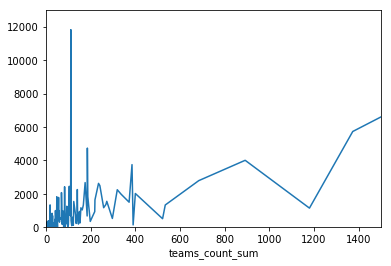

In [9]:
df_agg_reset.groupby('teams_count_sum')['don_count_sum'].mean().plot(xlim=[0,1500], ylim=[0,13000])

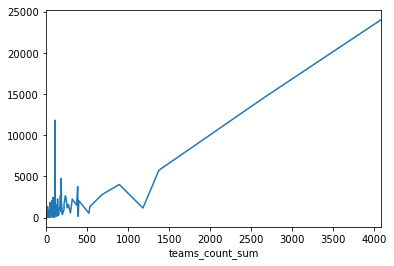

In [10]:
df_agg_reset.groupby('teams_count_sum')['don_count_sum'].mean().plot()

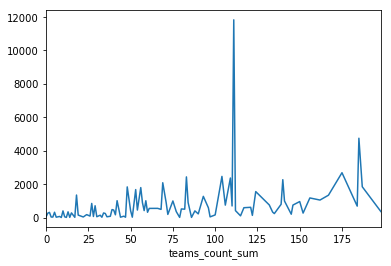

In [11]:
df_agg_reset[df_agg_reset.teams_count_sum<200].groupby('teams_count_sum')['don_count_sum'].mean().plot()

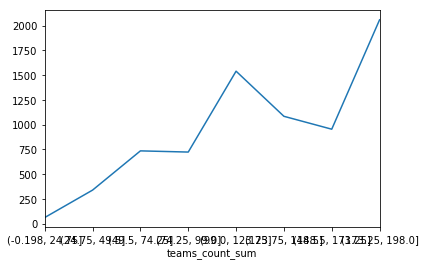

In [12]:
df_agg_reset[df_agg_reset.teams_count_sum<200].groupby(pd.cut(df_agg_reset[df_agg_reset.teams_count_sum<200]["teams_count_sum"], bins=8))['don_count_sum'].mean().plot()

In [13]:
df_agg_reset[df_agg_reset.teams_count_sum<200].groupby(pd.cut(df_agg_reset[df_agg_reset.teams_count_sum<200]["teams_count_sum"], bins=4))['don_count_sum'].mean()

teams_count_sum
(-0.198, 49.5]      74.120611
(49.5, 99.0]       729.794118
(99.0, 148.5]     1334.709677
(148.5, 198.0]    1507.000000
Name: don_count_sum, dtype: float64

In [14]:
team_count_grouped = df_agg_reset.groupby('teams_count_sum')['don_count_sum'].mean()
per_team_donation = team_count_grouped.values/team_count_grouped.index

teams_count_sum    13.473191
dtype: float64


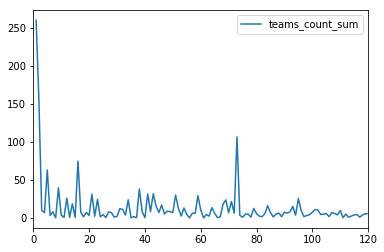

In [15]:
print(pd.DataFrame(per_team_donation[1:]).mean())
pd.DataFrame(per_team_donation).plot()

## Aggregated registrant donation exploration

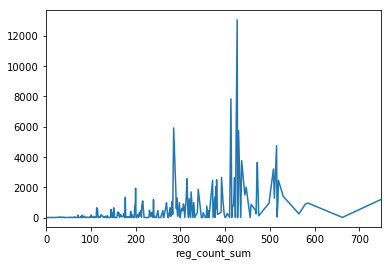

In [17]:
df_agg_reset.groupby('reg_count_sum')['don_count_sum'].mean().plot()

In [18]:
df_agg_reset.groupby(pd.cut(df_agg_reset["reg_count_sum"], bins=8))['don_count_sum'].mean()

reg_count_sum
(-0.748, 93.5]       8.123393
(93.5, 187.0]      116.951724
(187.0, 280.5]     301.428571
(280.5, 374.0]     817.578125
(374.0, 467.5]    2096.948718
(467.5, 561.0]    1692.500000
(561.0, 654.5]     691.333333
(654.5, 748.0]     596.000000
Name: don_count_sum, dtype: float64

In [19]:
reg_count_grouped = df_agg_reset.groupby('reg_count_sum')['don_count_sum'].mean()
per_reg_donation = reg_count_grouped.values/reg_count_grouped.index

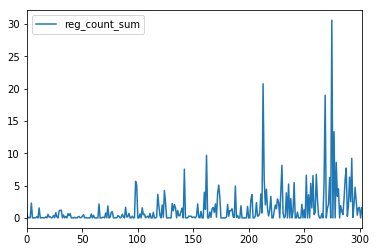

In [20]:
df_per_reg = pd.DataFrame(per_reg_donation[1:])
df_per_reg.plot()

In [21]:
df_per_reg.groupby(pd.cut(df_per_reg['reg_count_sum'], bins=8)).mean()

,reg_count_sum
reg_count_sum,
"(-0.0306, 3.819]",0.609260
"(3.819, 7.639]",5.384977
"(7.639, 11.458]",8.659826
"(11.458, 15.278]",13.334884
"(15.278, 19.097]",18.964891
"(19.097, 22.916]",20.736842
"(22.916, 26.736]",NaN
"(26.736, 30.555]",30.555035


## Team member vs nonteam member

The per team numbers appear fairly static but I would be interested in seeing how the numbers break down between team members and non-team members. Do registrants who are part of a team raise more than independent registrants?

In [32]:
tm_df = pd.read_csv("~/Repositories/datasets/logs/logs_all.csv")
team_members = tm_df[tm_df.is_team_join==True].message_registration.unique()

/Users/jeremyvanvalkenburg/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [33]:
len(team_members)

75636

In [61]:
trans = pd.read_csv("~/Repositories/datasets/transactions.csv")
trans['is_team_member'] = trans.apply(lambda x: x.transDonationEntityType==10 and x.transDonationEntity in team_members, axis=1)

In [63]:
trans[trans.transDonationEntityType==10].is_team_member.value_counts()

False    76682
True     63716
Name: is_team_member, dtype: int64

In [76]:
tms = trans[(trans.transDonationEntityType==10)&(trans.is_team_member==True)]
len_tms = len(tms.transDonationEntity.unique())

print("Team members: {}".format(len_tms))
print("\ttrans count per: {}".format(float(len(tms)) / float(len_tms)))
print("\tfunds raised per: {}".format(float(tms.amount.sum()) / float(len_tms)))

ntms = trans[(trans.transDonationEntityType==10)&(trans.is_team_member==False)]
len_ntms = len(ntms.transDonationEntity.unique())

print("Independents: {}".format(len_ntms))
print("\ttrans count per: {}".format(float(len(ntms)) / float(len_ntms)))
print("\tfunds raised per: {}".format(float(ntms.amount.sum()) / float(len_ntms)))

Team members: 24809
	trans count per: 2.568261518
	funds raised per: 177.791541779
Independents: 19138
	trans count per: 4.00679276831
	funds raised per: 310.578126764


In [71]:
grpd_tm = trans[trans.transDonationEntityType==10].groupby('is_team_member')
grpd_tm.agg({'amount': 'mean', 'transDonationEntity': 'count'})

,amount,transDonationEntity
is_team_member,,
False,77.512900,76682
True,69.226417,63716


In [77]:
trans.columns

Index([u'Unnamed: 0', u'amount', u'creatingTransactionFor', u'donations_amt',
       u'donations_count', u'email', u'events_amt', u'events_count',
       u'events_tickets', u'form', u'id', u'org', u'purchases_amt',
       u'purchases_count', u'purchases_quantity', u'recurring',
       u'recurring_creatingTransaction', u'registrations_amt',
       u'registrations_count', u'source', u'state', u'timestamp',
       u'transDonationEntity', u'transDonationEntityType', u'zip',
       u'is_team_member'],
      dtype='object')

# Per Registration Donation for Top Performing Events

In [15]:
form_agg = df_reg.groupby('form')[['don_volume', 'reg_count', 'don_count']].sum().reset_index()
top_performers = form_agg.sort_values("don_volume", ascending=False).head()
top_performers

,form,don_volume,reg_count,don_count
304,856152,1897909.32,427,24000
351,865391,729605.83,413,14634
569,915585,460504.97,285,11820
461,904288,434548.07,290,3381
563,915572,428126.48,508,3202


In [14]:
top_performers['don_volume'].mean() / top_performers['reg_count'].mean()

2054.4434061362463

In [16]:
top_performers['don_count'].mean() / top_performers['reg_count'].mean()

29.66042641705668

In [17]:
2054.44 / 29.66

69.26635198921106